# 최종

# business.json
- Yelp 비즈니스 데이터 불러오기
    - business.json을 JSON Lines 형식으로 읽어옴.

- 불필요한 컬럼 제거

    - 위치정보, 영업시간, 상세 속성 등 분석에 필요 없는 컬럼 삭제.

- 도시명 정제

    - Philadelphia 관련 표현들을 모두 "Philadelphia"로 통일.

- 카테고리 / 지역 필터링

    - food.txt와 restaurant.txt에 정의된 타겟 카테고리와 일치하는 비즈니스만 선택.

    - 미국 내에서 가장 많은 음식점이 있는 주(state)를 기준으로 Philadelphia에 위치한 데이터만 선택.

- 결측치 제거

    - 공백("")이나 NaN이 포함된 행 제거.

- 파일 저장

    - 최종적으로 정제된 비즈니스 정보를 business.json으로 저장.

In [5]:
import pandas as pd
import json

# JSON Lines 형식으로 business.json 불러오기
df_B = pd.read_json("data/raw/yelp_academic_dataset_business.json", lines=True)

In [6]:
business_df=df_B.copy()

In [7]:
# 제거할 컬럼 목록
drop_cols = ['postal_code', 'latitude', 'longitude', 'attributes', 'hours']

# 컬럼 제거
business_df = business_df.drop(columns=drop_cols)

# "city" 컬럼 내 값을 통일: Philadelphia 관련은 모두 "Philadelphia"로 변경
business_df.loc[business_df['city'].str.lower().str.contains("philadelphia", na=False),'city'] = "Philadelphia"

# 카테고리 불러오기 함수
def load_categories(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return set(line.strip() for line in f if line.strip())

# 파일 경로
food_path = "data/food.txt"
restaurant_path = "data/restaurant.txt"

# 타겟 카테고리 준비
food_categories = load_categories(food_path)
restaurant_categories = load_categories(restaurant_path)
target_categories = food_categories.union(restaurant_categories)

# 필터링 함수
def category_match(row):
    if isinstance(row, str):
        biz_categories = set(cat.strip() for cat in row.split(","))
        return bool(biz_categories & target_categories)
    return False

# ✅ 필터링 적용
business_food_df = business_df[business_df["categories"].apply(category_match)]

# 가장 많은 state 값 구하기 - PA
top_state = business_food_df['state'].value_counts().idxmax()
business_pa_df = business_food_df[business_food_df['state'] == top_state]
business_paph_df = business_pa_df[business_pa_df['city'] == "Philadelphia"]

In [14]:
# 각 컬럼별로 공백("") 또는 NaN 값 개수 계산
def count_empty_or_blank(series):
    return series.apply(lambda x: pd.isna(x) or (isinstance(x, str) and x.strip() == "")).sum()

empty_counts = business_paph_df.apply(count_empty_or_blank)
print("📊 각 컬럼별 공백 또는 결측치 개수:")
print(empty_counts)

📊 각 컬럼별 공백 또는 결측치 개수:
business_id      0
name             0
address         56
city             0
state            0
stars            0
review_count     0
is_open          0
categories       0
dtype: int64


In [16]:
# 공백 또는 NaN 판단 함수
def is_blank_or_nan(x):
    return pd.isna(x) or (isinstance(x, str) and x.strip() == "")

# 셀 단위 검사: 각 컬럼에 대해 .map() 적용 → 행 단위로 any() 검사
mask = business_paph_df.apply(lambda col: col.map(is_blank_or_nan)).any(axis=1)

# 조건에 해당하는 행 제거
business_paph_df_2 = business_paph_df[~mask].reset_index(drop=True)

In [17]:
empty_counts = business_paph_df_2.apply(count_empty_or_blank)
print("📊 각 컬럼별 공백 또는 결측치 개수:")
print(empty_counts)

📊 각 컬럼별 공백 또는 결측치 개수:
business_id     0
name            0
address         0
city            0
state           0
stars           0
review_count    0
is_open         0
categories      0
dtype: int64


In [18]:
output_path = "data/output/business.json"

# ✅ JSON Lines 형식으로 저장
business_paph_df_2.to_json(output_path, orient="records", lines=True, force_ascii=False)

print(f"✅ 총 {len(business_paph_df_2)}개 항목이 '{output_path}'에 저장되었습니다.")

✅ 총 6855개 항목이 'data/output/business.json'에 저장되었습니다.


# review.json
- PA 지역 philadelphia 도시
- 필요없는 column 제거

In [9]:
import pandas as pd

# 파일 경로
file_path = "data/raw/yelp_academic_dataset_review.json"

# chunk 단위로 전체 데이터 읽고 합치기
chunk_size = 100000
chunks = pd.read_json(file_path, lines=True, chunksize=chunk_size)

# 모든 chunk를 리스트에 담아서 연결
df_r = pd.concat(chunk for chunk in chunks)

In [20]:
df_review = df_r.copy()

In [21]:
import pandas as pd
import json

# PA - Philadelphia 리뷰
business_ids = set(business_paph_df["business_id"])

# business_id 기준 필터링
df_review = df_review[df_review["business_id"].isin(business_ids)]

# funny와 cool 컬럼 제거
df_review = df_review.drop(columns=["funny", "cool"])

In [22]:
# 각 컬럼별로 공백("") 또는 NaN 값 개수 계산
def count_empty_or_blank(series):
    return series.apply(lambda x: pd.isna(x) or (isinstance(x, str) and x.strip() == "")).sum()

empty_counts = df_review.apply(count_empty_or_blank)
print("📊 각 컬럼별 공백 또는 결측치 개수:")
print(empty_counts)

📊 각 컬럼별 공백 또는 결측치 개수:
review_id      0
user_id        0
business_id    0
stars          0
useful         0
text           0
date           0
dtype: int64


In [23]:
# 📚 필요 라이브러리 임포트
import pandas as pd
import re
from tqdm import tqdm
from transformers import DebertaV2Tokenizer

# tqdm pandas 적용
tqdm.pandas()

# ✅ 전처리 전/후 데이터 복사
df_raw = df_review.copy()
df_cleaned = df_review.copy()

# 🧼 전처리 함수 정의 (엔터 제거 포함)
def clean_for_deberta(text):
    text = text.strip().lower()
    text = text.replace("\n", " ").replace("\r", " ")  # 줄바꿈 제거
    text = re.sub(r"http\S+", "", text)               # URL 제거
    text = re.sub(r"\s+", " ", text)                  # 공백 정리
    return text

# 🔧 전처리 적용
df_cleaned["cleaned_text"] = df_cleaned["text"].progress_apply(clean_for_deberta)

# 🧠 DeBERTa 토크나이저 로드
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")

# 🔍 토큰 길이 계산 (tqdm 적용)
df_raw["token_length"] = df_raw["text"].progress_apply(lambda x: len(tokenizer.tokenize(x)))
df_cleaned["token_length"] = df_cleaned["cleaned_text"].progress_apply(lambda x: len(tokenizer.tokenize(x)))

# 📊 512 초과 리뷰 수 집계
over_512_raw = (df_raw["token_length"] > 512).sum()
over_512_cleaned = (df_cleaned["token_length"] > 512).sum()

# 📈 결과 요약
total = len(df_raw)
print("📊 전처리 전")
print(f"- 512 토큰 초과 리뷰 수: {over_512_raw} / {total}")
print(f"- 비율: {over_512_raw / total * 100:.2f}%")

print("\n📊 전처리 후")
print(f"- 512 토큰 초과 리뷰 수: {over_512_cleaned} / {total}")
print(f"- 비율: {over_512_cleaned / total * 100:.2f}%")

100%|██████████| 732435/732435 [02:14<00:00, 5454.17it/s]


📊 전처리 전
- 512 토큰 초과 리뷰 수: 11532 / 732435
- 비율: 1.57%

📊 전처리 후
- 512 토큰 초과 리뷰 수: 11568 / 732435
- 비율: 1.58%


In [24]:
df_raw.to_json("data/output/review.json", orient="records", lines=True, force_ascii=False)
df_cleaned.to_json("data/result/review_cleaned_0510.json", orient="records", lines=True, force_ascii=False)

# user.json
- 필요 없는 column 제거
- PA지역 Philadelphia 도시에 review 5개 이상 작성한 사용자

In [26]:
import pandas as pd

# 파일 경로 설정
file_path = "data/raw/yelp_academic_dataset_user.json"

# 1. chunk 단위로 불러오기
chunks = pd.read_json(file_path, lines=True, chunksize=100000)

# 2. 모든 chunk 읽고 합치기
df_u = pd.concat(chunk for chunk in chunks)

In [36]:
df_user = df_u.copy()
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 333.7+ MB


In [37]:
# 제거할 컬럼 리스트
drop_columns = [
    "yelping_since", "funny", "cool", "elite", "friends", "fans", 
    "compliment_hot", "compliment_more", "compliment_profile", "compliment_cute",
    "compliment_list", "compliment_note", "compliment_plain", "compliment_cool",
    "compliment_funny", "compliment_writer", "compliment_photos"
]

# 제거 수행
df_user = df_user.drop(columns=drop_columns)

In [38]:
# 각 컬럼별로 공백("") 또는 NaN 값 개수 계산
def count_empty_or_blank(series):
    return series.apply(lambda x: pd.isna(x) or (isinstance(x, str) and x.strip() == "")).sum()

empty_counts = df_user.apply(count_empty_or_blank)
print("📊 각 컬럼별 공백 또는 결측치 개수:")
print(empty_counts)

📊 각 컬럼별 공백 또는 결측치 개수:
user_id          0
name             0
review_count     0
useful           0
average_stars    0
dtype: int64


In [39]:
# 1. user_id별 리뷰 수 집계
review_counts = df_review["user_id"].value_counts()

# 2. 리뷰 수 5개 이상인 유저 수
num_users_5plus = (review_counts >= 5).sum()

# ✅ 전체 유저 수는 고유한 user_id 수로 계산해야 함
total_users = df_review["user_id"].nunique()

# 3. 비율 계산
ratio = num_users_5plus / total_users * 100

# 4. 출력
print(f"✅ 리뷰를 5개 이상 쓴 유저 수: {num_users_5plus}")
print(f"전체 유저 중 비율: {ratio:.2f}%")

✅ 리뷰를 5개 이상 쓴 유저 수: 28518
전체 유저 중 비율: 13.23%


In [40]:
# user_id별 리뷰 수 분포 집계
review_dist = review_counts.value_counts().sort_index()

# 결과 출력
print("📊 유저별 리뷰 수 분포 (리뷰 수 : 유저 수)")
for count, user_num in review_dist.items():
    print(f"{count}개: {user_num}명")

📊 유저별 리뷰 수 분포 (리뷰 수 : 유저 수)
1개: 128037명
2개: 34251명
3개: 15793명
4개: 9003명
5개: 5700명
6개: 4036명
7개: 2869명
8개: 2240명
9개: 1712명
10개: 1323명
11개: 1104명
12개: 989명
13개: 757명
14개: 647명
15개: 567명
16개: 479명
17개: 453명
18개: 359명
19개: 330명
20개: 287명
21개: 268명
22개: 258명
23개: 199명
24개: 222명
25개: 170명
26개: 193명
27개: 131명
28개: 140명
29개: 130명
30개: 127명
31개: 125명
32개: 92명
33개: 97명
34개: 101명
35개: 67명
36개: 81명
37개: 80명
38개: 74명
39개: 70명
40개: 59명
41개: 73명
42개: 57명
43개: 61명
44개: 56명
45개: 58명
46개: 54명
47개: 49명
48개: 53명
49개: 44명
50개: 49명
51개: 37명
52개: 33명
53개: 36명
54개: 35명
55개: 34명
56개: 32명
57개: 24명
58개: 26명
59개: 28명
60개: 32명
61개: 29명
62개: 24명
63개: 21명
64개: 18명
65개: 21명
66개: 25명
67개: 21명
68개: 26명
69개: 18명
70개: 23명
71개: 25명
72개: 19명
73개: 19명
74개: 18명
75개: 19명
76개: 14명
77개: 20명
78개: 17명
79개: 18명
80개: 18명
81개: 10명
82개: 11명
83개: 13명
84개: 9명
85개: 12명
86개: 8명
87개: 7명
88개: 10명
89개: 20명
90개: 13명
91개: 11명
92개: 10명
93개: 7명
94개: 5명
95개: 5명
96개: 12명
97개: 14명
98개: 7명
99개: 11명
100개: 11명
101개: 7명
102개: 8명
103개: 13명
104개: 8명
105

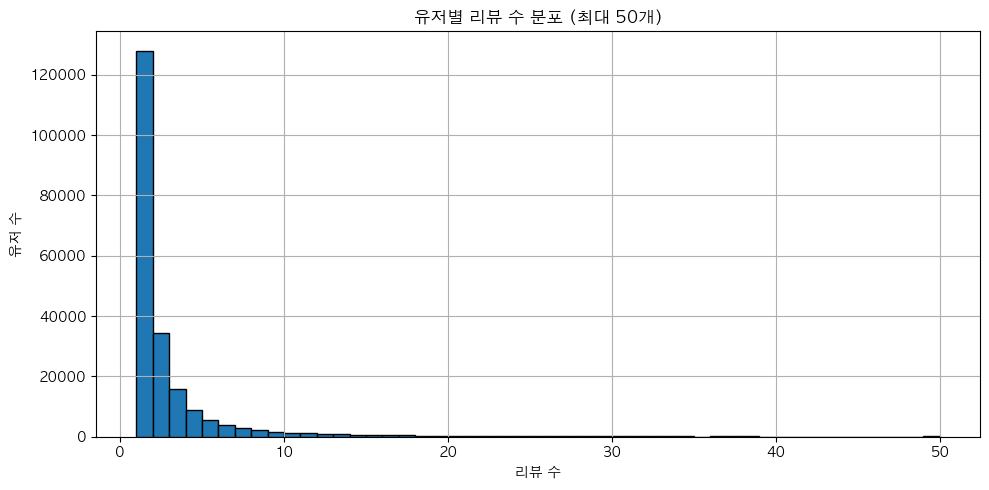

In [42]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ✅ OS에 따라 기본 한글 폰트 지정
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (Colab 등)
    plt.rcParams['font.family'] = 'NanumGothic'

# ✅ 마이너 경고 제거 (음수 값 처리 관련)
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(10, 5))
plt.hist(review_counts, bins=range(1, 51), edgecolor='black')  # 상위 50개까지
plt.title("유저별 리뷰 수 분포 (최대 50개)")
plt.xlabel("리뷰 수")
plt.ylabel("유저 수")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# 1. user_id별 리뷰 수 집계
review_counts = df_review["user_id"].value_counts()

# 2. 전체 유저 수 및 리뷰 수
total_users = len(review_counts)
total_reviews = review_counts.sum()
mean_reviews = review_counts.mean()

# 3. 리뷰를 5개 이상 쓴 유저 추출
review_counts_5plus = review_counts[review_counts >= 5]
num_users_5plus = len(review_counts_5plus)
total_reviews_5plus = review_counts_5plus.sum()
mean_reviews_5plus = review_counts_5plus.mean()

# 4. 출력
print(f"📊 전체 유저 수: {total_users:,}")
print(f"📝 전체 리뷰 수: {total_reviews:,}")
print(f"📈 전체 유저 평균 리뷰 수: {mean_reviews:.2f}")

print(f"\n✅ 리뷰 5개 이상 유저 수: {num_users_5plus:,}")
print(f"🧾 이들이 작성한 총 리뷰 수: {total_reviews_5plus:,}")
print(f"📊 전체 리뷰에서 차지하는 비율: {total_reviews_5plus / total_reviews * 100:.2f}%")
print(f"📈 5개 이상 유저의 평균 리뷰 수: {mean_reviews_5plus:.2f}")

📊 전체 유저 수: 215,602
📝 전체 리뷰 수: 732,435
📈 전체 유저 평균 리뷰 수: 3.40

✅ 리뷰 5개 이상 유저 수: 28,518
🧾 이들이 작성한 총 리뷰 수: 452,505
📊 전체 리뷰에서 차지하는 비율: 61.78%
📈 5개 이상 유저의 평균 리뷰 수: 15.87


In [45]:
# user_id별 PA-Philadelphia 리뷰 수 세기
review_counts = df_review['user_id'].value_counts()

# 리뷰가 5개 이상인 user_id만 추출
user_ids_5plus = review_counts[review_counts >= 5].index

# df_user에서 해당 user_id에 해당하는 사용자 정보만 필터링
df_user = df_user[df_user['user_id'].isin(user_ids_5plus)]

In [46]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28518 entries, 1 to 1908265
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        28518 non-null  object 
 1   name           28518 non-null  object 
 2   review_count   28518 non-null  int64  
 3   useful         28518 non-null  int64  
 4   average_stars  28518 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.3+ MB


In [47]:
df_user.to_json("data/output/user.json", orient="records", lines=True, force_ascii=False)

# 관련 근거
📌 데이터 전처리의 중요성
데이터 전처리는 머신러닝 및 데이터 마이닝에서 필수적인 단계로, 데이터 품질 향상과 모델 성능을 높이는 데 중요한 역할을 합니다.

참고문헌:
García, S., Luengo, J., & Herrera, F. (2015). Data Preprocessing in Data Mining. Springer.

🔗 https://link.springer.com/book/10.1007/978-3-319-10247-4

이 문헌은 데이터 마이닝 과정에서의 필수적 데이터 정제(preprocessing)의 중요성을 강조하며, 불필요한 컬럼의 제거, 데이터 통합 및 정제 등을 효과적으로 수행해야 모델 성능이 향상된다고 설명합니다.

📌 하이브리드 추천 시스템과 감성 분석의 결합
협업 필터링과 콘텐츠 기반 필터링을 결합한 하이브리드 추천 시스템은 사용자 리뷰에서 감성 정보를 추가로 활용하여 추천의 정확도를 높일 수 있습니다.

참고문헌:
Kumar, S., Halder, S. S., De, K., & Roy, P. P. (2018). Movie Recommendation System using Sentiment Analysis from Microblogging Data. arXiv preprint arXiv:1811.10804.

🔗 https://arxiv.org/abs/1811.10804

본 논문에서는 사용자 리뷰의 감성 분석을 통해 개인화된 추천 정확도를 향상시키는 접근법을 제시하며, 지역 및 카테고리 특성도 중요하게 고려합니다.

📌 음식점 추천 시스템에서의 감성 분석 활용
사용자의 리뷰 데이터에서 음식에 대한 감성을 분석하여 음식점 추천 시스템에 반영하는 연구입니다.

참고문헌:
Asani, E., Vahdat-Nejad, H., & Sadri, J. (2021). Restaurant recommender system based on sentiment analysis. Machine Learning with Applications, 6, 100114.

🔗 https://www.sciencedirect.com/science/article/pii/S2666827021000638

본 논문에서는 사용자의 리뷰 데이터를 기반으로 감성 분석을 수행하여, 사용자의 개인적 선호와 감정적 반응을 적극적으로 활용하는 추천 시스템을 구축합니다.
